[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
여기서 우리의 목표는 이진 분류를 위한 2계층 신경망을 구현하고, 경사하강법을 사용하여 훈련하고, 홍채 데이터 세트를 분류하는 데 사용하는 것입니다.
우리 모델은
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
여기서 $M$ 은닉 유닛과 $D$ 입력 기능이 있습니다. 즉 $w \in \mathbb{R}^{M}$ 및 $V \in \mathbb{R}^{M \times D}입니다. $ 여기에서는 단순화를 위해 각 레이어에 대한 바이어스 매개변수를 포함하지 않습니다. 구현의 핵심은 기울기 계산입니다.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [3]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    def __init__(self, M = 64):
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = [dv, dw]
            return dparams
        
        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v,w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh

위의 구현에서 우리는 모델 매개변수와 그 기울기를 유지하기 위해 목록 데이터 구조를 사용했습니다. 아래에서 매개변수 목록과 함께 작동하도록 `GradientDescent` 클래스를 수정했습니다.여기서는 벡터 및 행렬 연산을 사용하여 *모든* 매개변수에 대한 도함수를 계산합니다.

In [4]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

## Iris dataset
이것을 적용하여 붓꽃 ​​데이터셋으로 이진 분류를 해보자.
아래에서 우리는 많은 반복에 대해 경사하강법을 실행하고 결정 경계를 플로팅합니다.

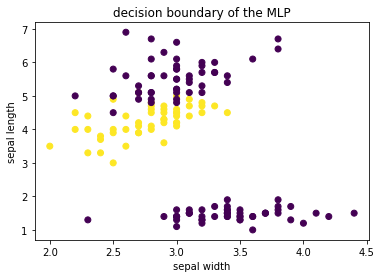

In [7]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1
model = MLP(M=64)
optimizer = GradientDescent(learning_rate=.1, max_iters=20000)
yh = model.fit(x, y, optimizer).predict(x) 
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > .5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()